<a href="https://colab.research.google.com/github/attatrol/MADE_ML_Homeworks/blob/master/ML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
import random

In [2]:
try:
    with open('../../datasets/covid/owid-covid-data.csv', 'r') as iofile:
        data = pd.read_csv('owid-covid-data.csv')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv -nc
    with open('owid-covid-data.csv', 'r') as iofile:
        data = pd.read_csv('owid-covid-data.csv')

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

--2020-05-13 06:58:11--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2647230 (2.5M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]   2.52M  --.-KB/s    in 0.07s   

2020-05-13 06:58:11 (37.4 MB/s) - ‘owid-covid-data.csv’ saved [2647230/2647230]



In [3]:
data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [4]:
print(datetime.datetime(2020, 3, 3))
# print(data["date"][0].timestamp())

2020-03-03 00:00:00


In [0]:
def filter_data(iso_code = "RUS", from_date = datetime.datetime(2020, 3, 3)):
  return data[(data['iso_code'] == iso_code) & (data['date'] >= from_date)]

In [6]:
rus_data = filter_data()
rus_data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
13450,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13451,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13452,RUS,Russia,2020-03-05,4,0,0,0,0.027,0.000,0.0,0.0,46414.0,NaN,0.318,NaN,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13453,RUS,Russia,2020-03-06,4,0,0,0,0.027,0.000,0.0,0.0,51366.0,4952.0,0.352,0.034,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13454,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,0.0,55688.0,4322.0,0.382,0.030,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05


In [0]:
def print_data(data):
  _, ax = plt.subplots()
  ax.plot(data['date'], data['new_cases'], label = "cases")
  ax.plot(data['date'], data['new_deaths'], label = "deaths")
  ax.plot(data['date'], data['new_tests'], label = "tests")
  ax.set(title='Sequential')
  ax.grid()
  ax.set_yscale("log")
  plt.legend()
  plt.show()

  _, ax = plt.subplots()
  ax.plot(data['date'], data['total_cases'], label = "cases")
  ax.plot(data['date'], data['total_deaths'], label = "deaths")
  ax.plot(data['date'], data['total_tests'], label = "tests")
  ax.set(title='Cumulative')
  ax.grid()
  ax.set_yscale("log")
  plt.legend()
  plt.show()

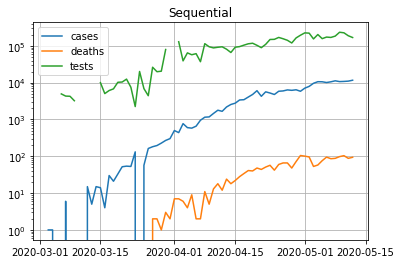

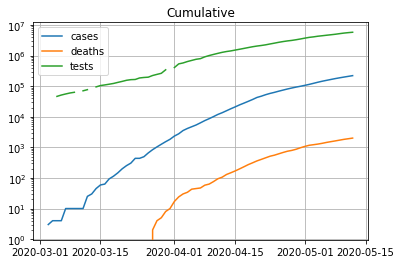

In [8]:
print_data(rus_data)

2.a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших:  
 y ~ exp(линейная функция от x), где x — номер текущего дня.

 Решим эту задачу как ln (y) ~ ax + b

In [0]:
def prepare_data(data):
  train = data[:50]
  test = data[50:]
  train_y = train['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  train_x = np.asarray(range(0, train_y.size), dtype = np.int32)
  test_y = test['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  test_x = np.asarray(range(train_y.size, test_y.size + train_y.size), dtype = np.int32)
  return train_x, train_y, test_x, test_y

In [0]:
def train_linear(data):
  train_x, train_y, test_x, test_y = prepare_data(rus_data)
  model = linear_model.LinearRegression(fit_intercept=True).fit(train_x.reshape(-1, 1), train_y)
  train_tredict = model.predict(train_x.reshape(-1, 1))
  test_predict = model.predict(test_x.reshape(-1, 1))

  _, ax = plt.subplots()
  ax.plot(test_x, test_y, label = "test_x")
  ax.plot(train_x, train_y, label = "train_x")
  ax.plot(test_x, test_predict, label = "test_x_predict")
  ax.plot(train_x, train_tredict, label = "train_x_tredict")
  ax.set(title='Sigmoid prediction')
  ax.grid()
  plt.legend()
  plt.show()
  return model

Я решил не выходить из логарифмических координат, и в них все весьма наглядно:

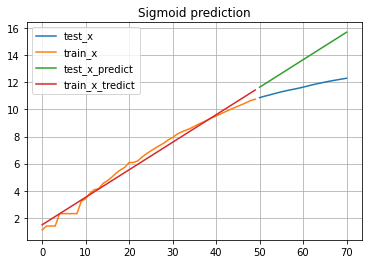

In [11]:
rus_model = train_linear(rus_data)

2.b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Значение beta для текущей модели 0.0021413503258041204


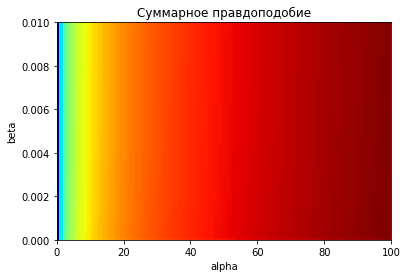

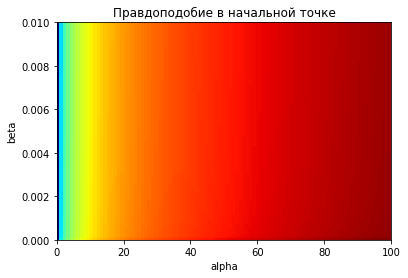

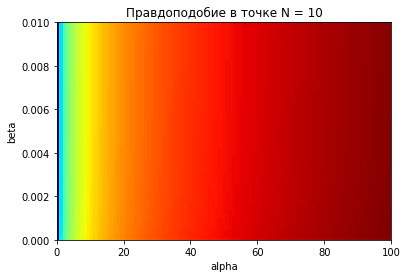

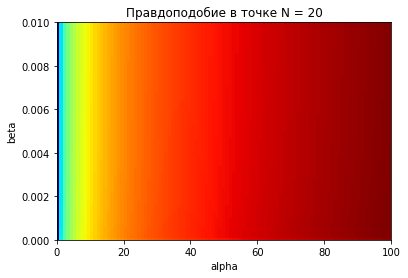

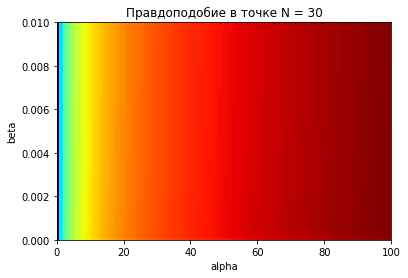

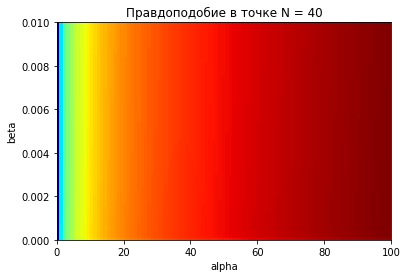

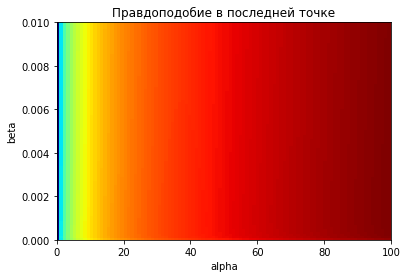

In [12]:
# логарифм апостериорного распределения гиперпараметров alpha beta
# так как p(a,b) = 1, то оно же - правдоподобие alpha и beta при условии точки данных
def ab_posterior(alpha, beta, x, y, N):
  A = beta * x * x + alpha
  m_N = beta * x * y / A
  return math.log(alpha) / 2 + math.log(beta) * N / 2 \
        - beta / 2 * (y - x * m_N) * (y - x * m_N) \
        - alpha / 2 * m_N * m_N \
        - math.log(abs(A)) - N / 2 * math.log(2 * 3.14)

# просуммировать ab_posterior по всем точкам данных
# используя текущую модель
def ab_posterior_vectorized(point_num = 100):
  probs_alpha = np.arange(0.01, 100.001, 100 / point_num)
  probs_beta = np.arange(0.00001, 0.01001, 0.01 / point_num)
  train_x, train_y, test_x, test_y = prepare_data(rus_data)
  test_predict = rus_model.predict(train_x.reshape(-1, 1))
  sq_sum = 0
  for k in range(train_x.size):
    sq_sum = sq_sum + (train_x[k] - test_predict[k]) * (train_x[k] - test_predict[k])
  result = np.zeros(shape=(train_x.size + 1, point_num, point_num))
  for i in range(point_num):
    for j in range(point_num):
      for k in range(train_x.size):
        result[k][i][j] = ab_posterior(probs_alpha[i], probs_beta[j], train_x[k], train_y[k], train_x.size)
        result[train_x.size][i][j] = result[train_x.size][i][j] + result[k][i][j]
  return result, train_x.size, (train_x.size - 1) / sq_sum

def plot_heatmap(Z, title, point_num):
    plt.xlim((0, 100))
    plt.ylim((0, 0.01))
    X = np.linspace(0, 100, point_num)
    Y = np.linspace(0, 0.01, point_num)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    # print(Z)
    plt.title(title)
    plt.xlabel("alpha")
    plt.ylabel("beta")
    plt.show()

# построить тепловую карту взаимного распределения apha и beta
def ab_posterior_heatmap(point_num = 100):
    Z, total_idx, current_beta = ab_posterior_vectorized(point_num)
    print("Значение beta для текущей модели", current_beta)

    plot_heatmap(Z[total_idx], "Суммарное правдоподобие", point_num)
    plot_heatmap(Z[0], "Правдоподобие в начальной точке", point_num)
    for i in range(10, total_idx - 1, 10):
      plot_heatmap(Z[i], "Правдоподобие в точке N = " + str(i), point_num)
    plot_heatmap(Z[total_idx - 1], "Правдоподобие в последней точке", point_num)

ab_posterior_heatmap()

Как интерпретировать те факты, что   
1. beta не имеет явно выраженного максимума, совпадающего со значение beta для текущей модели, 
2. alpha непрерывно возрастает, вместо того, чтобы иметь максимум около нуля  

я не знаю. Скорее всего я посчитал что-то не так.

2.с. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

[59, 120, 182]


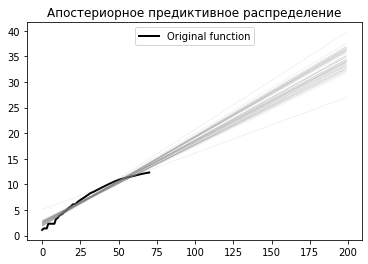

Прогноз заболеваемости
1 мая 151444+-55353.309688064124
1 июля 2834237192+-5100286624.323775
1 сентября 62324177727652+-313209293460576.25


In [25]:
def sample(x, y):
  xs = []
  ys = []
  for i in range(x.size):
    if random.random() > 0.8:
      xs.append(x[i])
      ys.append(y[i])
  return np.asarray(xs, dtype = np.int32), np.asarray(ys)

def days_between(d1, d2):
  return abs((d2 - d1).days)

def mean_variance_as_string(sample):
  sample = np.asarray(sample)
  return str(round(math.exp(sample.mean()))) + "+-" + str(math.exp(sample.mean() + sample.std()) - math.exp(sample.mean()))

def sample_train_plot(data):
  y = data['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  x = np.asarray(range(0, y.size), dtype = np.int32)
  
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(x, y, linewidth=2, label="Original function", color="black")

  dates = [ \
           days_between(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 3, 3)), \
           days_between(datetime.datetime(2020, 7, 1), datetime.datetime(2020, 3, 3)), \
           days_between(datetime.datetime(2020, 9, 1), datetime.datetime(2020, 3, 3)) \
          ]
  date_samples = [[], [], []]
  print(dates)

  x_predict = np.asarray(range(0, 200), dtype = np.int32)
  res = []
  for _ in range(50):
      xs, ys = sample(x, y)
      model = linear_model.LinearRegression(fit_intercept=True).fit(xs.reshape(-1, 1), ys)
      res.append(model.predict(x_predict.reshape(-1, 1)))
      ax.plot(x_predict, res[-1], linewidth=.1, color="0.5")
      for i in range(len(dates)):
        date_samples[i].append(res[-1][dates[i]])

  ax.legend(loc="upper center")
  plt.title('Апостериорное предиктивное распределение')
  plt.show()

  print("Прогноз заболеваемости")
  print("1 мая " + mean_variance_as_string(date_samples[0]))
  print("1 июля " + mean_variance_as_string(date_samples[1]))
  print("1 сентября " + mean_variance_as_string(date_samples[2]))

sample_train_plot(rus_data)